# Vanilla RNN
V1 by Didi (under review)

In [1]:
from scipy import stats
import numpy as np

# Version with step-by-step loss

In [2]:
# Dict to convert movement idx to actual movement coordinates
idx2mov = {0:np.array([1,0], dtype=int), 
           1:np.array([-1,0], dtype=int), 
           2:np.array([0,1], dtype=int), 
           3:np.array([0,-1], dtype=int)}

# Convert coordinate to flattened idx
def loc2idx(loc, grid_size=np.array([5, 5], dtype=int)):
    return loc[0]*grid_size[0] + loc[1]

# Convert location flattened idx to coordinate
def idx2loc(idx, grid_size=np.array([5, 5], dtype=int)):
    return np.array([idx // grid_size[0], idx % grid_size[0]], dtype=int)


def sample_n_back_spatial(n, p_stop=0.05, max_length=40, grid_size=np.array([5, 5], dtype=int), boundary='periodic', return_trajectory=False):
    """
    Function to generate a sample for the n-back spatial task.

    Args:
    - n: response delay
    - p_stop: after n steps, probability of stoping walk (default=0.05)
    - max_length: maximum trajectory length (left zero-padding is applied to reach this length)
    - grid_size (array-like): size of gridworld, must be odd (default=[5,5])
    - boundary ['periodic', 'strict']: boundary conditions
    - return_trajectory (bool): whether to return trajectory

    Returns: movements (1D array, as index), n_back_idx (n-back location as idx), (trajectory) 
    
    """
    assert boundary in ['periodic', 'strict'], "boundary must be either 'periodic' or 'strict'"
    assert (grid_size[0] % 2 == 1) & (grid_size[1] % 2 == 1), "grid size must be odd"

    zero = np.array([(grid_size[0]-1)//2, (grid_size[1]-1)//2], dtype=int)
    movements = np.random.randint(4, size=max_length)
    
    trajectory = [zero]
    
    for idx in movements:
        if boundary == 'periodic':
            trajectory.append((trajectory[-1] + idx2mov[idx]) % grid_size)
        elif boundary == 'strict':
            trajectory.append(np.clip(trajectory[-1] + idx2mov[idx], a_min=[0,0], a_max=grid_size-1))
        
    trajectory = np.array(trajectory)

    n_back_idx = np.array([loc2idx(trajectory[i], grid_size=grid_size) for i in range(max_length-n)])

    if return_trajectory:
        return movements, n_back_idx, trajectory
    else:
        return movements, n_back_idx


In [3]:
sample_n_back_spatial(2, boundary='strict')

(array([3, 0, 3, 1, 1, 2, 0, 0, 1, 1, 1, 1, 2, 3, 3, 2, 0, 1, 2, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 1, 1, 3, 0, 0, 3, 3, 2], dtype=int32),
 array([12, 11, 16, 15, 10,  5,  6, 11, 16, 11,  6,  1,  1,  2,  1,  0,  1,
         6,  1,  2,  7, 12,  7, 12,  7, 12,  7, 12, 17, 22, 22, 23, 23, 18,
        13, 12, 17, 22]))

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch

class NBackDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
		
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def create_n_back_dataset(num_samples, n, p_stop=0.05, max_length=40, grid_size=np.array([5, 5], dtype=int), boundary='periodic'):
    X, Y = [], []
    for _ in range(num_samples):
        x, y = sample_n_back_spatial(n, p_stop=p_stop, max_length=max_length, grid_size=grid_size, boundary=boundary)
        X.append(x); Y.append(y)

    X = np.vstack(X)
    Y = np.vstack(Y)

    X = torch.tensor(X, dtype=int)
    Y = torch.tensor(Y, dtype=int)

    return NBackDataset(X, Y)

In [5]:
data = create_n_back_dataset(100, 3)
data[0][1].size()

torch.Size([37])

In [6]:
import torch.nn.functional as F
from torch import nn

class RNNExplorer(nn.Module):
    
    def __init__(self, n_back, hidden_state_size, num_layers=1, grid_size=np.array([5, 5], dtype=int), dropout=0.2):

        super(RNNExplorer, self).__init__()

        self.n_back = n_back
        self.hidden_state_size = hidden_state_size
        self.output_size = grid_size[0]*grid_size[1]
        self.num_layers = num_layers

        self.core = nn.RNN(4, self.hidden_state_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Linear(self.hidden_state_size, self.output_size)

    def forward(self, X, return_hidden=False):

        X = F.one_hot(X, num_classes=4).to(torch.float32)
        h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_state_size).to(X.device)

        if return_hidden:
            states, hidden = self.core(X, h0)
        else:
            states, _= self.core(X, h0)
        
        logits = self.head(self.dropout(states[:, self.n_back:, :]))
        
        if return_hidden:
            return logits.transpose(1,2), hidden
        else:
            return logits.transpose(1,2)

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss_list = []
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_list.append(loss.item())

    return np.mean(loss_list)
#            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).mean().item()
    test_loss /= num_batches
    correct /= num_batches
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

In [8]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [9]:
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR

batch_size = 1000
epochs = 200
train_sample_size = 100_000
test_sample_size = 10_000

n_back = 10
hidden_units = 128
num_layers = 1
lr = 0.001

def sample_and_train(n_back, hidden_units, num_layers=1, train_sample_size=100_000, test_sample_size=10_000, batch_size=1000, epochs=10, lr=0.001, dropout=0.2, l2_reg=0.):

    train_dataloader = DataLoader(create_n_back_dataset(train_sample_size, n_back, boundary='strict'), batch_size=batch_size)
    test_dataloader = DataLoader(create_n_back_dataset(test_sample_size, n_back, boundary='strict'), batch_size=batch_size)
        
    
    model = RNNExplorer(n_back, hidden_units, num_layers=num_layers).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)
    # scheduler = ExponentialLR(optimizer, gamma=0.9)
    
    acc, test_loss, train_loss = [], [], []
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        tr = train(train_dataloader, model, loss_fn, optimizer)
        a, t = test(test_dataloader, model, loss_fn)
        acc.append(a); test_loss.append(t); train_loss.append(tr)
    #    scheduler.step()
    print("Done!")

    return model, acc, test_loss, train_loss

In [10]:
np.random.seed(0)

_, acc, test_loss, train_loss = sample_and_train(20, 64, num_layers=1, dropout=0.2, l2_reg=0.00, lr=0.00125, batch_size=128, epochs=10)

c:\Users\diego\miniconda3\envs\neuroai-2025\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.1%, Avg loss: 3.164992 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 9.3%, Avg loss: 3.203474 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 13.5%, Avg loss: 3.056723 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 13.0%, Avg loss: 2.856803 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 13.1%, Avg loss: 2.830077 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 13.5%, Avg loss: 2.819102 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 15.5%, Avg loss: 2.767105 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 15.8%, Avg loss: 2.754409 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 16.9%, Avg loss: 2.703421 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 16.1%, Avg loss: 2.719514 

Done!


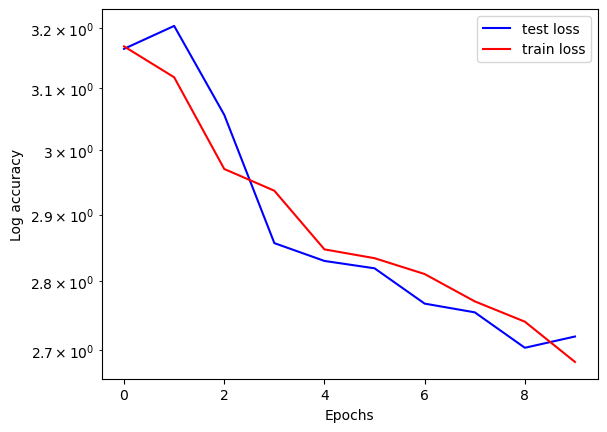

In [15]:
import matplotlib.pyplot as plt

plt.plot(test_loss, color='b')
plt.plot(train_loss, color='r')
plt.legend(['test loss', 'train loss'])
plt.xlabel('Epochs')
plt.ylabel('Log accuracy')
plt.yscale('log')

In [ ]:
import itertools as itt
from tqdm import tqdm

list_hidden_units = [64, 128, 258]#, 512]
list_n_back = np.arange(21)

grid_dict = { 
    'acc' : [],
    'test_loss' : [],
    'train_loss': [],
    'hidden_units' : [],
    'n_back' : [],
}

for hidden_units, n_back in tqdm(itt.product(list_hidden_units, list_n_back)):

    print(f"Computing with {hidden_units} hidden units, {n_back}-back task")
    _, acc, test_loss, train_loss = sample_and_train(n_back, hidden_units, num_layers=1, lr=0.00125, batch_size=128, epochs=10)

    grid_dict['acc'].append(np.array(acc))
    grid_dict['test_loss'].append(np.array(test_loss))
    grid_dict['train_loss'].append(np.array(train_loss))
    grid_dict['hidden_units'].append(hidden_units)
    grid_dict['n_back'].append(n_back)

0it [00:00, ?it/s]

Computing with 64 hidden units, 0-back task


c:\Users\diego\miniconda3\envs\neuroai-2025\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1
-------------------------------
Test Error: 
 Accuracy: 94.9%, Avg loss: 0.338742 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.057996 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.014689 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006074 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 96.2%, Avg loss: 0.157169 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001789 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001410 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000834 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000522 

Epoch 10
-------------------------------


1it [03:47, 227.11s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000316 

Done!
Computing with 64 hidden units, 1-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 89.2%, Avg loss: 0.493132 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.114966 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.056452 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.065392 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.021664 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.138282 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002196 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001619 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001041 

Epoch 10
-------------------------------


2it [07:23, 220.81s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000708 

Done!
Computing with 64 hidden units, 2-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 25.5%, Avg loss: 1.640807 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.697460 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 92.8%, Avg loss: 0.339069 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.150152 

Epoch 5
-------------------------------


In [ ]:
import pandas as pd

grid_df = pd.DataFrame(grid_dict)

grid_df.to_csv('n_back_acc.csv')
grid_df.to_pickle('n_back_acc.pkl')

/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

<Axes: xlabel='n_back', ylabel='acc_max'>

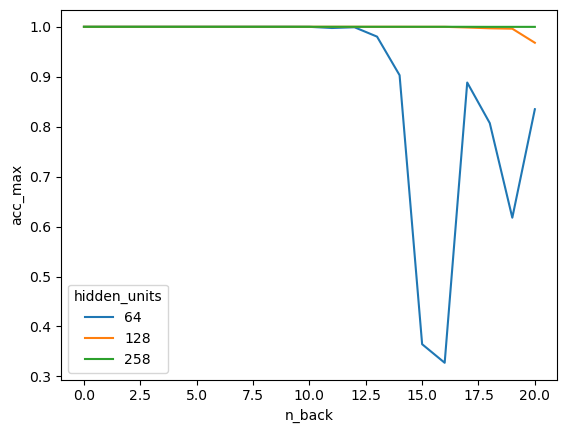

In [ ]:
grid_df['acc_max'] = grid_df['acc'].apply(np.max)

import seaborn as sns

sns.lineplot(x='n_back', y='acc_max', hue=grid_df['hidden_units'].astype(str), data=grid_df)